In [29]:
#Modelo distilBERT
#Libreria transformers (modelo BERT predefinido para la clasificación (BertForSequenceClassification))
#Libreria sera BERT + Capa de clasificación por encima
#Debemos tokenizar nuestro dataset (tokens + attention mask + max_length)

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, SequentialSampler
from transformers import DistilBertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import torch.optim
import numpy as np
import pandas as pd
import time
import datetime
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from bs4 import BeautifulSoup
from transformers import DistilBertTokenizerFast, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from textwrap import wrap
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re,string
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
from collections import Counter

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras 
from keras import backend as K
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM,Dense,Bidirectional,Input
from keras.models import Model
import torch
import transformers

# Pandas options
pd.options.display.max_colwidth = 280

MAX_LEN = 38

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Select cpu or cuda
run_on = 'cpu'
device = torch.device(run_on)

df_train = pd.read_csv('/Users/nfanlo/dev/spanish-classifier-tfg/dataset/60-20-20/train.csv')
print(df_train.shape)
df_train.isnull().sum()
df_train.sentiment.replace("P" , 2 , inplace = True)
df_train.sentiment.replace("N" , 0 , inplace = True)
df_train.sentiment.replace("NEU" , 1, inplace = True)
df_train.head()
df_train['review'] = df_train['text']
df_train.drop('text', axis=1, inplace=True)
df_train['label'] = df_train['sentiment']
df_train.drop('sentiment', axis=1, inplace=True)

df_dev = pd.read_csv('/Users/nfanlo/dev/spanish-classifier-tfg/dataset/60-20-20/dev.csv')
print(df_dev.shape)
df_dev.isnull().sum()
df_dev.sentiment.replace("P" , 2 , inplace = True)
df_dev.sentiment.replace("N" , 0 , inplace = True)
df_dev.sentiment.replace("NEU" , 1, inplace = True)
df_dev['review'] = df_dev['text']
df_dev.drop('text', axis=1, inplace=True)
df_dev['label'] = df_dev['sentiment']
df_dev.drop('sentiment', axis=1, inplace=True)



(4340, 2)
(1447, 2)


In [30]:

print(df_train.head(1))

                                                                  review  \
0  @Jorge_LBU Espero que te mejores pronto, vomitar es muy desagradable    

   label  
0      0  


In [32]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS


#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [33]:
def clean_reviews(df):
    cleaned_reviews = []
    for t in df.review:
        cleaned_reviews.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(t)))))
    return cleaned_reviews


review_new_train = clean_reviews(df_train)
review_new_dev = clean_reviews(df_dev)

In [35]:
print(df_train.head(1))

                                                     review  label
0  espero que te mejores pronto vomitar es muy desagradable      0


In [20]:
review_new_train = []
review_new_dev = []
for t in df_train.review:
    review_new_train.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(t)))))

for t in df_dev.review:
    review_new_dev.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(t)))))

In [34]:
df_train['review'] = review_new_train
df_dev['review'] = review_new_dev

In [9]:
X_train = df_train.iloc[:, 0]
y_train = df_train.iloc[:, 1]
X_dev = df_dev.iloc[:, 0]
y_dev = df_dev.iloc[:, 1]

In [44]:
# Tokenization

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased',
            do_lower_case=True)

def preprocessing(dataset):
    input_ids = []
    attention_mask = []
    for doc in dataset:
        encoded_doc = tokenizer.encode_plus(doc,
                   add_special_tokens=True, max_length=MAX_LEN,
                   truncation=True ,pad_to_max_length=True,
                   return_token_type_ids = False,
                   return_attention_mask = True,)
        input_ids.append(encoded_doc['input_ids'])
        attention_mask.append(encoded_doc['attention_mask'])
    return (torch.tensor(input_ids),
           torch.tensor(attention_mask))

# Apply preprocessing to dataset
X_train_inputs, X_train_masks = preprocessing(X_train)
X_dev_inputs, X_dev_masks = preprocessing(X_dev)

# Report max n° tokens in a sentence
max_len = max([torch.sum(sen) for sen in X_train_masks])
print('Max n°tokens in a sentence: {0}'.format(max_len))

/Users/nfanlo/Library/Python/3.8/lib/python/site-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Max n°tokens in a sentence: 38


In [45]:
#Data loaders
batch_size = 8

y_train_labels = torch.tensor(y_train.values)
y_dev_labels = torch.tensor(y_dev.values)

def dataloader(x_inputs, x_masks, y_labels):
    data = TensorDataset(x_inputs, x_masks, y_labels)
    sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size, num_workers=4)
    
    return dataloader

train_dataloader = dataloader(X_train_inputs, X_train_masks, y_train_labels)
val_dataloader = dataloader(X_dev_inputs, X_dev_masks, y_dev_labels)

In [46]:
#Cargamos el modelo + optimizador + definimos EPOCHS + Scheduler
#Modelo
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3,
 output_attentions=False, output_hidden_states=False)

optimizer = AdamW(model.parameters(), lr = 5e-5, eps = 1e-6)

epochs=4

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps= total_steps)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

In [47]:
print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [48]:
#Definimos una funcion para formatear el tiempo y otra para calcular la exactitud
#fuction to format time
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

#function to compute accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

======= Epoch 1 / 4 =======
======= Epoch 2 / 4 =======
======= Epoch 3 / 4 =======
======= Epoch 4 / 4 =======


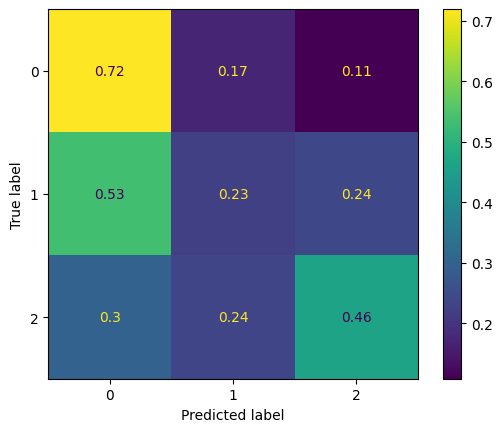

              precision    recall  f1-score   support

           1       0.55      0.72      0.62       599
           2       0.33      0.23      0.27       440
           3       0.53      0.46      0.49       408

    accuracy                           0.50      1447
   macro avg       0.47      0.47      0.46      1447
weighted avg       0.48      0.50      0.48      1447



In [49]:
#Definimos la funcion para entrenar el modelo y entregar los resultados en el set de validación
#Train model
def training(n_epochs, training_dataloader, validation_dataloader):
    for epoch_i in range(0, n_epochs):
        print('======= Epoch {:} / {:} ======='.format(epoch_i + 1, epochs))
        # Mira cuanto tiempo le cuesta entrenar un EPOCH.
        t0 = time.time()
        # Resetea la perdida para este EPOCH.
        total_loss = 0
        # Pone el modelo en modo entrenamiento.
        model.train()
        # Para cada batch en el training data
        for step, batch in enumerate(training_dataloader):
            batch_loss = 0
            # Unpack this training batch from dataloader
            #   [0]: input ids, [1]: attention masks, 
            #   [2]: labels
            b_input_ids,b_input_mask, b_labels = tuple(
                                t.to(device) for t in batch)

            # Limpia el gradiente calculado anteriormente
            model.zero_grad()

            # Genera un paso adelante
            outputs = model(b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_labels)

            # Saca el loss value fuera del output
            loss = outputs[0]
            batch_loss += loss.item()
            total_loss += loss.item()

            # Genera un paso atras
            loss.backward()

            # Clipea el los gradientes a 1.0.
            torch.nn.utils.clip_grad_norm_(model.parameters(),
                                            1.0)

            # Actualiza los parametros
            # ¿take a step using the computed gradient?
            optimizer.step()
            scheduler.step()

        # Calcula el average loss sobre el training data.
        avg_train_loss = total_loss / len(train_dataloader)

        #Validación
        # Despues de completar un entrenamiento genera un paso de validacion


        t0 = time.time()

        # Pone el modelo en modo evaluación
        model.eval()

        # Trackea las variables
        eval_loss, eval_accuracy = 0, 0
        all_logits = []
        all_labels = []
        # Evalua el data para un epoch mas
        for step, batch in enumerate(validation_dataloader):
            # Add batch to device
            # Unpack this training batch from our dataloader.
            #   [0]: input ids, [1]: attention masks,
            #   [2]: labels
            b_input_ids, b_input_mask, b_labels = tuple(
                                t.to(device) for t in batch)


            # El modelo no computa los gradientes
            with torch.no_grad():
                # Paso adelante 
                # Devolvemos los loggits 
                outputs = model(b_input_ids,
                                attention_mask=b_input_mask)

            # Los "logits" son el valor de salida
            # Prioriza aplicar la funcion de activación
            logits = outputs[0]

            # Mueve los logits y labels a la CPU
            logits = logits.detach().cpu().numpy()
            b_labels = b_labels.to('cpu').numpy()

            # Guarda los logits y labels del batch
            # Utilizamos esto en la matriz de confusión
            predict_labels = np.argmax(logits, axis=1).flatten()
            all_logits.extend(predict_labels.tolist())
            all_labels.extend(b_labels.tolist())

            # Calcula la precision para este batch
            tmp_eval_accuracy = flat_accuracy(logits, b_labels)
            # Accumula la precisión total
            eval_accuracy += tmp_eval_accuracy
    
    #Print la matriz de confussión"
    conf = confusion_matrix(all_labels, all_logits, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=conf)
    disp.plot()
    plt.show()

    target_names = ['1', '2', '3']
    print(classification_report(all_labels, all_logits, target_names=target_names))





#Llamamos a la funcion para entrenar el modelo
training(epochs, train_dataloader, val_dataloader)

In [11]:
#DistilBERT with no clearing the stopwords, square brackets, etc... + distilBERT cased

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, SequentialSampler
from transformers import DistilBertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import torch.optim
import numpy as np
import pandas as pd
import time
import datetime
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from bs4 import BeautifulSoup
from transformers import DistilBertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from textwrap import wrap
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
from collections import Counter

import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras 
from keras import backend as K
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM,Dense,Bidirectional,Input
from keras.models import Model
import torch
import transformers

MAX_LEN = 38

# Select cpu or cuda
run_on = 'cpu'
device = torch.device(run_on)

df_train = pd.read_csv('/Users/nfanlo/dev/spanish-classifier-tfg/dataset/60-20-20/train.csv')
print(df_train.shape)
df_train.isnull().sum()
df_train.sentiment.replace("P" , 2 , inplace = True)
df_train.sentiment.replace("N" , 0 , inplace = True)
df_train.sentiment.replace("NEU" , 1, inplace = True)
df_train.head()
df_train['review'] = df_train['text']
df_train.drop('text', axis=1, inplace=True)
df_train['label'] = df_train['sentiment']
df_train.drop('sentiment', axis=1, inplace=True)

df_dev = pd.read_csv('/Users/nfanlo/dev/spanish-classifier-tfg/dataset/60-20-20/dev.csv')
print(df_dev.shape)
df_dev.isnull().sum()
df_dev.sentiment.replace("P" , 2 , inplace = True)
df_dev.sentiment.replace("N" , 0 , inplace = True)
df_dev.sentiment.replace("NEU" , 1, inplace = True)
df_dev['review'] = df_dev['text']
df_dev.drop('text', axis=1, inplace=True)
df_dev['label'] = df_dev['sentiment']
df_dev.drop('sentiment', axis=1, inplace=True)

(4340, 2)
(1447, 2)


In [12]:
print(df_train)

                                                 review  label
0     @Jorge_LBU Espero que te mejores pronto, vomit...      0
1     @ClubPaniniMx @PaniniComicsMx genial espero qu...      1
2                     kali uchis va a estar en bahidorá      1
3     @ferdiazgil @FranDguez sí, lo he leído ese tem...      0
4     @AbrahamMateoESP Exacto! Todo lo que él hace l...      1
...                                                 ...    ...
4335               tu en serio por que sois tan tontos       0
4336  Yo muchísimo mas . Hablamos al DM y te paso él...      1
4337  Les platicó algo bonito? Bueno pues, el último...      2
4338           Una breve reseña de quien soy realmente.      1
4339                   @MicaGiudice el tuyo quedo mejor      2

[4340 rows x 2 columns]


In [13]:
X_train = df_train.iloc[:, 0]
y_train = df_train.iloc[:, 1]
X_dev = df_dev.iloc[:, 0]
y_dev = df_dev.iloc[:, 1]

In [14]:
# Tokenization

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased',
            do_lower_case=True)

def preprocessing(dataset):
    input_ids = []
    attention_mask = []
    for doc in dataset:
        encoded_doc = tokenizer.encode_plus(doc,
                   add_special_tokens=True, max_length=MAX_LEN,
                   truncation=True ,pad_to_max_length=True,
                   return_token_type_ids = False,
                   return_attention_mask = True,)
        input_ids.append(encoded_doc['input_ids'])
        attention_mask.append(encoded_doc['attention_mask'])
    return (torch.tensor(input_ids),
           torch.tensor(attention_mask))

# Apply preprocessing to dataset
X_train_inputs, X_train_masks = preprocessing(X_train)
X_dev_inputs, X_dev_masks = preprocessing(X_dev)

# Report max n° tokens in a sentence
max_len = max([torch.sum(sen) for sen in X_train_masks])
print('Max n°tokens in a sentence: {0}'.format(max_len))

Downloading: 100%|██████████| 213k/213k [00:00<00:00, 391kB/s] 
Downloading: 100%|██████████| 29.0/29.0 [00:00<00:00, 7.66kB/s]
Downloading: 100%|██████████| 411/411 [00:00<00:00, 146kB/s]
/Users/nfanlo/Library/Python/3.8/lib/python/site-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Max n°tokens in a sentence: 38


In [15]:
#Data loaders
batch_size = 8

y_train_labels = torch.tensor(y_train.values)
y_dev_labels = torch.tensor(y_dev.values)

def dataloader(x_inputs, x_masks, y_labels):
    data = TensorDataset(x_inputs, x_masks, y_labels)
    sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size, num_workers=4)
    
    return dataloader

train_dataloader = dataloader(X_train_inputs, X_train_masks, y_train_labels)
val_dataloader = dataloader(X_dev_inputs, X_dev_masks, y_dev_labels)

In [17]:
#Cargamos el modelo + optimizador + definimos EPOCHS + Scheduler
#Modelo
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=3,
 output_attentions=False, output_hidden_states=False)

optimizer = AdamW(model.parameters(), lr = 5e-5, eps = 1e-6)

epochs=4

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps= total_steps)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classifier

In [18]:
print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [19]:
#Definimos una funcion para formatear el tiempo y otra para calcular la exactitud
#fuction to format time
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

#function to compute accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

======= Epoch 1 / 4 =======
======= Epoch 2 / 4 =======
======= Epoch 3 / 4 =======
======= Epoch 4 / 4 =======


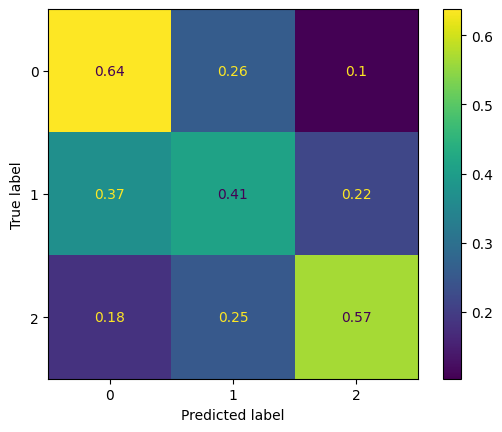

              precision    recall  f1-score   support

           1       0.62      0.64      0.63       599
           2       0.41      0.41      0.41       440
           3       0.59      0.57      0.58       408

    accuracy                           0.55      1447
   macro avg       0.54      0.54      0.54      1447
weighted avg       0.55      0.55      0.55      1447



In [20]:
#Definimos la funcion para entrenar el modelo y entregar los resultados en el set de validación
#Train model
def training(n_epochs, training_dataloader, validation_dataloader):
    for epoch_i in range(0, n_epochs):
        print('======= Epoch {:} / {:} ======='.format(epoch_i + 1, epochs))
        # Mira cuanto tiempo le cuesta entrenar un EPOCH.
        t0 = time.time()
        # Resetea la perdida para este EPOCH.
        total_loss = 0
        # Pone el modelo en modo entrenamiento.
        model.train()
        # Para cada batch en el training data
        for step, batch in enumerate(training_dataloader):
            batch_loss = 0
            # Unpack this training batch from dataloader
            #   [0]: input ids, [1]: attention masks, 
            #   [2]: labels
            b_input_ids,b_input_mask, b_labels = tuple(
                                t.to(device) for t in batch)

            # Limpia el gradiente calculado anteriormente
            model.zero_grad()

            # Genera un paso adelante
            outputs = model(b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_labels)

            # Saca el loss value fuera del output
            loss = outputs[0]
            batch_loss += loss.item()
            total_loss += loss.item()

            # Genera un paso atras
            loss.backward()

            # Clipea el los gradientes a 1.0.
            torch.nn.utils.clip_grad_norm_(model.parameters(),
                                            1.0)

            # Actualiza los parametros
            # ¿take a step using the computed gradient?
            optimizer.step()
            scheduler.step()

        # Calcula el average loss sobre el training data.
        avg_train_loss = total_loss / len(train_dataloader)

        #Validación
        # Despues de completar un entrenamiento genera un paso de validacion


        t0 = time.time()

        # Pone el modelo en modo evaluación
        model.eval()

        # Trackea las variables
        eval_loss, eval_accuracy = 0, 0
        all_logits = []
        all_labels = []
        # Evalua el data para un epoch mas
        for step, batch in enumerate(validation_dataloader):
            # Add batch to device
            # Unpack this training batch from our dataloader.
            #   [0]: input ids, [1]: attention masks,
            #   [2]: labels
            b_input_ids, b_input_mask, b_labels = tuple(
                                t.to(device) for t in batch)


            # El modelo no computa los gradientes
            with torch.no_grad():
                # Paso adelante 
                # Devolvemos los loggits 
                outputs = model(b_input_ids,
                                attention_mask=b_input_mask)

            # Los "logits" son el valor de salida
            # Prioriza aplicar la funcion de activación
            logits = outputs[0]

            # Mueve los logits y labels a la CPU
            logits = logits.detach().cpu().numpy()
            b_labels = b_labels.to('cpu').numpy()

            # Guarda los logits y labels del batch
            # Utilizamos esto en la matriz de confusión
            predict_labels = np.argmax(logits, axis=1).flatten()
            all_logits.extend(predict_labels.tolist())
            all_labels.extend(b_labels.tolist())

            # Calcula la precision para este batch
            tmp_eval_accuracy = flat_accuracy(logits, b_labels)
            # Accumula la precisión total
            eval_accuracy += tmp_eval_accuracy
    
    #Print la matriz de confussión"
    conf = confusion_matrix(all_labels, all_logits, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=conf)
    disp.plot()
    plt.show()

    target_names = ['1', '2', '3']
    print(classification_report(all_labels, all_logits, target_names=target_names))





#Llamamos a la funcion para entrenar el modelo
training(epochs, train_dataloader, val_dataloader)

In [21]:
#DistilBERT with diferent learning rate (lr=5e-6)

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, SequentialSampler
from transformers import DistilBertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import torch.optim
import numpy as np
import pandas as pd
import time
import datetime
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from bs4 import BeautifulSoup
from transformers import DistilBertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from textwrap import wrap
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
from collections import Counter

import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras 
from keras import backend as K
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM,Dense,Bidirectional,Input
from keras.models import Model
import torch
import transformers

MAX_LEN = 38

# Select cpu or cuda
run_on = 'cpu'
device = torch.device(run_on)

df_train = pd.read_csv('/Users/nfanlo/dev/spanish-classifier-tfg/dataset/60-20-20/train.csv')
print(df_train.shape)
df_train.isnull().sum()
df_train.sentiment.replace("P" , 2 , inplace = True)
df_train.sentiment.replace("N" , 0 , inplace = True)
df_train.sentiment.replace("NEU" , 1, inplace = True)
df_train.head()
df_train['review'] = df_train['text']
df_train.drop('text', axis=1, inplace=True)
df_train['label'] = df_train['sentiment']
df_train.drop('sentiment', axis=1, inplace=True)

df_dev = pd.read_csv('/Users/nfanlo/dev/spanish-classifier-tfg/dataset/60-20-20/dev.csv')
print(df_dev.shape)
df_dev.isnull().sum()
df_dev.sentiment.replace("P" , 2 , inplace = True)
df_dev.sentiment.replace("N" , 0 , inplace = True)
df_dev.sentiment.replace("NEU" , 1, inplace = True)
df_dev['review'] = df_dev['text']
df_dev.drop('text', axis=1, inplace=True)
df_dev['label'] = df_dev['sentiment']
df_dev.drop('sentiment', axis=1, inplace=True)

(4340, 2)
(1447, 2)


In [22]:
#Environment stopwords for train
stop = set(stopwords.words('spanish'))
punctuation = list(string.punctuation)
stop.update(punctuation)

#Data cleaning stopwords (ignored)
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df_train['review']=df_train['review'].apply(denoise_text)

/Users/nfanlo/Library/Python/3.8/lib/python/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [23]:
#Environment stopwords for dev
stop = set(stopwords.words('spanish'))
punctuation = list(string.punctuation)
stop.update(punctuation)

#Data cleaning stopwords (ignored)
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df_dev['review']=df_dev['review'].apply(denoise_text)

In [24]:
X_train = df_train.iloc[:, 0]
y_train = df_train.iloc[:, 1]
X_dev = df_dev.iloc[:, 0]
y_dev = df_dev.iloc[:, 1]

In [25]:
# Tokenization

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',
            do_lower_case=True)

def preprocessing(dataset):
    input_ids = []
    attention_mask = []
    for doc in dataset:
        encoded_doc = tokenizer.encode_plus(doc,
                   add_special_tokens=True, max_length=MAX_LEN,
                   truncation=True ,pad_to_max_length=True,
                   return_token_type_ids = False,
                   return_attention_mask = True,)
        input_ids.append(encoded_doc['input_ids'])
        attention_mask.append(encoded_doc['attention_mask'])
    return (torch.tensor(input_ids),
           torch.tensor(attention_mask))

# Apply preprocessing to dataset
X_train_inputs, X_train_masks = preprocessing(X_train)
X_dev_inputs, X_dev_masks = preprocessing(X_dev)

# Report max n° tokens in a sentence
max_len = max([torch.sum(sen) for sen in X_train_masks])
print('Max n°tokens in a sentence: {0}'.format(max_len))

/Users/nfanlo/Library/Python/3.8/lib/python/site-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Max n°tokens in a sentence: 38


In [26]:
#Data loaders
batch_size = 8

y_train_labels = torch.tensor(y_train.values)
y_dev_labels = torch.tensor(y_dev.values)

def dataloader(x_inputs, x_masks, y_labels):
    data = TensorDataset(x_inputs, x_masks, y_labels)
    sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size, num_workers=4)
    
    return dataloader

train_dataloader = dataloader(X_train_inputs, X_train_masks, y_train_labels)
val_dataloader = dataloader(X_dev_inputs, X_dev_masks, y_dev_labels)

In [27]:
#Cargamos el modelo + optimizador + definimos EPOCHS + Scheduler
#Modelo
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3,
 output_attentions=False, output_hidden_states=False)

optimizer = AdamW(model.parameters(), lr = 5e-6, eps = 1e-6)

epochs=4

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps= total_steps)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

In [28]:
print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [29]:
#Definimos una funcion para formatear el tiempo y otra para calcular la exactitud
#fuction to format time
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

#function to compute accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

======= Epoch 1 / 4 =======
======= Epoch 2 / 4 =======
======= Epoch 3 / 4 =======
======= Epoch 4 / 4 =======


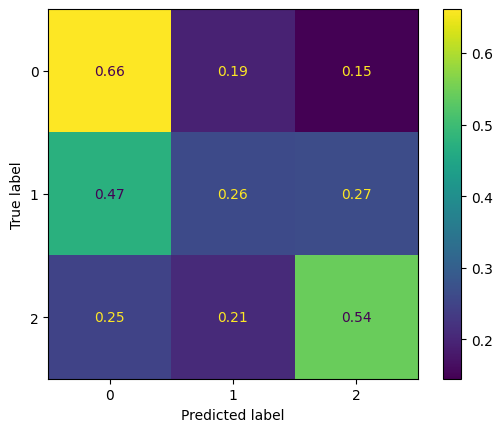

              precision    recall  f1-score   support

           1       0.56      0.66      0.61       599
           2       0.37      0.26      0.30       440
           3       0.52      0.54      0.53       408

    accuracy                           0.51      1447
   macro avg       0.48      0.49      0.48      1447
weighted avg       0.49      0.51      0.49      1447



In [30]:
#Definimos la funcion para entrenar el modelo y entregar los resultados en el set de validación
#Train model
def training(n_epochs, training_dataloader, validation_dataloader):
    for epoch_i in range(0, n_epochs):
        print('======= Epoch {:} / {:} ======='.format(epoch_i + 1, epochs))
        # Mira cuanto tiempo le cuesta entrenar un EPOCH.
        t0 = time.time()
        # Resetea la perdida para este EPOCH.
        total_loss = 0
        # Pone el modelo en modo entrenamiento.
        model.train()
        # Para cada batch en el training data
        for step, batch in enumerate(training_dataloader):
            batch_loss = 0
            # Unpack this training batch from dataloader
            #   [0]: input ids, [1]: attention masks, 
            #   [2]: labels
            b_input_ids,b_input_mask, b_labels = tuple(
                                t.to(device) for t in batch)

            # Limpia el gradiente calculado anteriormente
            model.zero_grad()

            # Genera un paso adelante
            outputs = model(b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_labels)

            # Saca el loss value fuera del output
            loss = outputs[0]
            batch_loss += loss.item()
            total_loss += loss.item()

            # Genera un paso atras
            loss.backward()

            # Clipea el los gradientes a 1.0.
            torch.nn.utils.clip_grad_norm_(model.parameters(),
                                            1.0)

            # Actualiza los parametros
            # ¿take a step using the computed gradient?
            optimizer.step()
            scheduler.step()

        # Calcula el average loss sobre el training data.
        avg_train_loss = total_loss / len(train_dataloader)

        #Validación
        # Despues de completar un entrenamiento genera un paso de validacion


        t0 = time.time()

        # Pone el modelo en modo evaluación
        model.eval()

        # Trackea las variables
        eval_loss, eval_accuracy = 0, 0
        all_logits = []
        all_labels = []
        # Evalua el data para un epoch mas
        for step, batch in enumerate(validation_dataloader):
            # Add batch to device
            # Unpack this training batch from our dataloader.
            #   [0]: input ids, [1]: attention masks,
            #   [2]: labels
            b_input_ids, b_input_mask, b_labels = tuple(
                                t.to(device) for t in batch)


            # El modelo no computa los gradientes
            with torch.no_grad():
                # Paso adelante 
                # Devolvemos los loggits 
                outputs = model(b_input_ids,
                                attention_mask=b_input_mask)

            # Los "logits" son el valor de salida
            # Prioriza aplicar la funcion de activación
            logits = outputs[0]

            # Mueve los logits y labels a la CPU
            logits = logits.detach().cpu().numpy()
            b_labels = b_labels.to('cpu').numpy()

            # Guarda los logits y labels del batch
            # Utilizamos esto en la matriz de confusión
            predict_labels = np.argmax(logits, axis=1).flatten()
            all_logits.extend(predict_labels.tolist())
            all_labels.extend(b_labels.tolist())

            # Calcula la precision para este batch
            tmp_eval_accuracy = flat_accuracy(logits, b_labels)
            # Accumula la precisión total
            eval_accuracy += tmp_eval_accuracy
    
    #Print la matriz de confussión"
    conf = confusion_matrix(all_labels, all_logits, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=conf)
    disp.plot()
    plt.show()

    target_names = ['1', '2', '3']
    print(classification_report(all_labels, all_logits, target_names=target_names))



#Llamamos a la funcion para entrenar el modelo
training(epochs, train_dataloader, val_dataloader)

    precision    recall  f1-score   support

distilBERT (dataclearing and lr=5e-5)

1       0.60      0.57      0.58       599
2       0.38      0.44      0.41       440
3       0.61      0.55      0.57       408

distilBERT (no dataclearing and lr=5e-5)

1       0.62      0.64      0.63       599
2       0.41      0.41      0.41       440
3       0.59      0.57      0.58       408

distilBERT (dataclearing and lr=5e-6)

1       0.56      0.66      0.61       599
2       0.37      0.26      0.30       440
3       0.52      0.54      0.53       408

distilBERT (newdataclearing and lr=5e-5)

1       0.55      0.72      0.62       599
2       0.33      0.23      0.27       440
3       0.53      0.46      0.49       408